# 1. Imports, Installs and some parameters

In [ ]:
!pip install -q -U langchain transformers bitsandbytes accelerate langchain_community

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
from huggingface_hub import HfApi, HfFolder, Repository
from huggingface_hub import login
from difflib import SequenceMatcher

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Dataset

In [3]:
device

device(type='cuda')

In [4]:
data_splits = {'train': 'main/train-00000-of-00001.parquet', 'test': 'main/test-00000-of-00001.parquet'}

In [5]:
train = pd.read_parquet("hf://datasets/openai/gsm8k/" + data_splits["train"])
test = pd.read_parquet("hf://datasets/openai/gsm8k/" + data_splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 3. Implement the methods

##Initiate the model

All methods use the same model - Mistral-7B.

In [13]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

#here is necessary to specify token for authentification from hugging face
login(token="")
model_4bit = AutoModelForCausalLM.from_pretrained( "mistralai/Mistral-7B-Instruct-v0.1", device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [14]:

generation_params = {
    'max_length': 1024,
    'pad_token_id': tokenizer.eos_token_id,
    'num_return_sequences': 1,
    'no_repeat_ngram_size': 2,
    'top_k': 50,
    'top_p': 0.95,
    'temperature': 1.0,
    'do_sample': True
}

model_4bit.config.update(generation_params)

Taking 5 example problem-solution pairs.

In [15]:
sample_problems = train.sample(5)
questions = sample_problems['question'].tolist()
true_answers = sample_problems['answer'].tolist()

## 3.1. Basic Prompting

Create a basic prompt for the LLM. Organize and label the structure of the question and answer.


In [16]:
def basic_prompting(input_data, model, tokenizer, device):
    prompt = f"Question: {input_data}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = generated_text.split("Answer:")[-1].strip()
    return answer

In [17]:
basic_answers = [basic_prompting(q, model_4bit, tokenizer, device) for q in questions]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


## 3.2. Prompt Engineering with Context

Structural labeling of questions and answers with added context taken from the dataset description on huggingface. Structure according to the lecture.

In [18]:
def prompt_engineering_with_context(input_data, model, tokenizer, device):
    context = "The dataset contains grade-school level math questions in English, emphasizing real-world applications and including considerations of units of measurement. This ensures a broad range of scenarios that enhance learning and comprehension.\n"
    prompt = f"C: {context}\nQuestion: {input_data}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    anwser = generated_text.split("Answer:")[-1].strip()
    return anwser

In [19]:
context_answers = [prompt_engineering_with_context(q, model_4bit, tokenizer, device) for q in questions]

## 3.3 Self-Consistency

In this approach, I build upon the foundational method by iteratively applying the model multiple times. I evaluate the generated answers against the correct answer using SequenceMatcher and retain the closest match as the final answer.

In [20]:
def self_consistency(input_data, correct_answer, model, tokenizer, device, n=5):
    generated_answers = []
    for _ in range(n):
        generated_answers.append(basic_prompting(input_data, model, tokenizer, device))
    best_answer = max(generated_answers, key=lambda ans: SequenceMatcher(None, ans, correct_answer).ratio())
    return best_answer

In [21]:
consistency_answers = [self_consistency(q, true_ans, model_4bit, tokenizer, device) for q, true_ans in zip(questions, true_answers)]

## 3.4. Zero-Shot and Few-Shot Learning

Zero-Shot Learning on the basic method

Few-Shot Learning: In this approach, I incorporate five randomly selected samples from the dataset into the prompt as illustrative examples.

In [22]:
def zero_shot_learning(input_data, model, tokenizer, device):
    prompt = f"Question: {input_data}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = generated_text.split("Answer:")[-1].strip()
    return answer

In [23]:
def few_shot_learning(input_data, examples, model, tokenizer, device):
    prompt = ""
    for ex in examples:
        prompt += f"Question: {ex['question']}\nAnswer: {ex['answer']}\n"
    prompt += f"Question: {input_data}\nA:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=1500)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = generated_text.split("Answer:")[-1].strip()
    return answer

In [24]:
zero_shot_answers = [zero_shot_learning(q, model_4bit, tokenizer, device) for q in questions]

In [25]:
few_shot_answers = [few_shot_learning(q, train.sample(5).to_dict('records'), model_4bit, tokenizer, device) for q in questions]

## 3.5. Chain of Thought

In this approach, I have designated specific models to provide step-by-step solutions.

In [38]:
def chain_of_thought(input_data, model, tokenizer, device):
    prompt = f"Question: {input_data}\nAnswer: Let's work through this math question step by step."
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = generated_text.split("Answer:")[-1].strip()
    return answer

In [39]:
cot_answers = [chain_of_thought(q, model_4bit, tokenizer, device) for q in questions]

## 3.6. Zero-Shot Chain of Thought


In [40]:
def zero_shot_chain_of_thought(input_data, model, tokenizer, device):
    prompt = f"Question: {input_data}\nAnswer: Let's break this down step by step.."
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = generated_text.split("Answer:")[-1].strip()
    return answer

In [41]:
zscot_answers = [zero_shot_chain_of_thought(q, model_4bit, tokenizer, device) for q in questions]

## 4. Evaluation Metrics

In [42]:
results = pd.DataFrame({
    "Question": questions,
    "True Answer": true_answers,
    "Basic": basic_answers,
    "Context": context_answers,
    "Consistency": consistency_answers,
    "Zero-Shot": zero_shot_answers,
    "Few-Shot": few_shot_answers,
    "CoT": cot_answers,
    "ZS-CoT": zscot_answers
})
results

,Question,True Answer,Basic,Context,Consistency,Zero-Shot,Few-Shot,CoT,ZS-CoT
0,A wood stove burns 4 bundles of wood in the mo...,Working out the difference between the amount ...,5 bundled of woods were burne,5 bundLES of WOOD were BURNED in THE afterNOON.,7 bundules of Wood burned,5 bundLES of WOOD,The Chicago Cubs scored 2 home runs in the thi...,Let's work through this math question step by ...,Let's break this down step by step..\n\n1. We ...
1,Maddy's 4th grade class needs to make 1000 Val...,"If 30 kids each make 8 cards, they will have m...",54,27 more Valentine cards are needed to have a c...,-36 cards,260 cards (1190 total- 939 made),The sell reduced the price of each pin by 20*....,Let's work through this math question step by ...,Let's break this down step by step.. \n1. We k...
2,Grant has four times as many vacations as Kelv...,Grant has 4*90 = <<4*90=360>>360 vacations.\nI...,360 vacizations and 180classes,Kelkin has a total of 144 classes and vacatioo...,Kelkin has a total of 36 classes and 180 vacin...,Kelkin has a total of 156 classes and vacances...,The total number of scoops of ice cream that M...,Let's work through this math question step by ...,Let's break this down step by step..\n\n1. We ...
3,Alex has 4 pens in the first week of a month. ...,If Alex has 4 pens in the first week of a mont...,-8,24,64 - 32 = 92 - number of pens Alex will having...,72 - 24 = 50\n\nSo Alex will still have more p...,First find how much Jed was above the speed li...,Let's work through this math question step by ...,Let's break this down step by step..\n1. We kn...
4,There were sweets on the table. Jack came and ...,"Jack took 4 more candies than the half, and Pa...",19 cand,22 sweeps were initially on table.\r\n\r\nThe ...,16 candics,18,"Since a day has 24 hours, the project was to t...",Let's work through this math question step by ...,Let's break this down step by step..\n\n1. At ...


Let's see all accuracies

### 4.1. Accuracy

Accuracy is straightforward to compute as the proportion of correct answers.

In [32]:
import nltk
from sklearn.metrics import f1_score

nltk.download('punkt')

def normalize_answer(s):
    """Lower text and remove punctuation, articles, and extra whitespace."""
    import string, re
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punctuation(text):
        return ''.join(ch for ch in text if ch not in string.punctuation)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punctuation(lower(s))))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [33]:
def accuracy(predictions, true_answers):
    correct = sum([1 if normalize_answer(p) == normalize_answer(t) else 0 for p, t in zip(predictions, true_answers)])
    return correct / len(true_answers)

In [34]:
print(f"Accuracy for Basic approach: {accuracy(basic_answers, true_answers)}")
print(f"Accuracy with Context: {accuracy(context_answers, true_answers)}")
print(f"Accuracy for Self-Consistency: {accuracy(consistency_answers, true_answers)}")
print(f"Accuracy for Zero-Shot Learning: {accuracy(zero_shot_answers, true_answers)}")
print(f"Accuracy for Few-Shot Learning: {accuracy(few_shot_answers, true_answers)}")
print(f"Accuracy for Chain of Thought: {accuracy(cot_answers, true_answers)}")
print(f"Accuracy for Zero-Shot Chain of Thought: {accuracy(zscot_answers, true_answers)}")

Accuracy for Basic approach: 0.0
Accuracy with Context: 0.0
Accuracy for Self-Consistency: 0.0
Accuracy for Zero-Shot Learning: 0.0
Accuracy for Few-Shot Learning: 0.0
Accuracy for Chain of Thought: 0.0
Accuracy for Zero-Shot Chain of Thought: 0.0



### 4.2. Reasoning Quality

The solution path demonstrates some reasoning, but it does not adhere to the correct logic.


### 4.3. Consistency

**Consistency**

To measure consistency, generate multiple responses for the same prompt and calculate the average pairwise similarity. We'll use a simple string similarity metric.

In [45]:
def consistency(preds, actual_answers):
    total_similarity = 0
    for predicted, actual in zip(preds, actual_answers):
        score = SequenceMatcher(None, predicted, actual).ratio()
        total_similarity += score

    average_similarity = total_similarity / len(preds)
    return average_similarity


In [48]:
consistency_basic = consistency(basic_answers, true_answers)
consistency_context = consistency(context_answers, true_answers)
consistency_sef_consist = consistency(consistency_answers, true_answers)
consistency_zero_shot = consistency(zero_shot_answers, true_answers)
consistency_few_shot = consistency(few_shot_answers, true_answers)
consistency_cot = consistency(cot_answers, true_answers)
consistency_zscot = consistency(zscot_answers, true_answers)

print(f"Consistency for Basic approach: {consistency_basic}")
print(f"Consistency with Context: {consistency_context}")
print(f"Consistency for Self-Consistency: {consistency_sef_consist}")
print(f"Consistency for Zero-Shot Learning: {consistency_zero_shot}")
print(f"Consistency for Few-Shot Learning: {consistency_few_shot}")
print(f"Consistency for Chain of Thought: {consistency_cot}")
print(f"Consistency for Zero-Shot Chain of Thought: {consistency_zscot}")

Consistency for Basic approach: 0.08093735333381842
Consistency with Context: 0.10535062161475181
Consistency for Self-Consistency: 0.11103283863920185
Consistency for Zero-Shot Learning: 0.09884525916671817
Consistency for Few-Shot Learning: 0.10866627471770454
Consistency for Chain of Thought: 0.10908170623412076
Consistency for Zero-Shot Chain of Thought: 0.10886375135413337


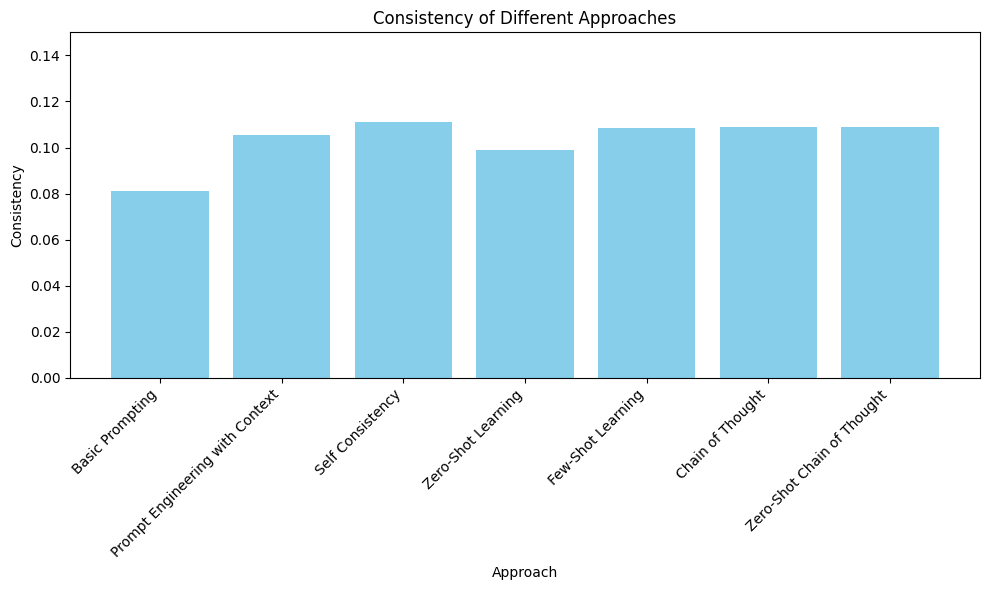

In [49]:
import matplotlib.pyplot as plt

# Define the consistencies and approaches
approaches = [
   'Basic Prompting',
   'Prompt Engineering with Context',
   'Self Consistency',
   'Zero-Shot Learning',
   'Few-Shot Learning',
   'Chain of Thought',
   'Zero-Shot Chain of Thought'
]

accuracies = [
    consistency_basic, consistency_context, consistency_sef_consist, consistency_zero_shot, consistency_few_shot, consistency_cot, consistency_zscot
]

# Plotting the consistencies
plt.figure(figsize=(10, 6))
plt.bar(approaches, accuracies, color='skyblue')
plt.xlabel('Approach')
plt.ylabel('Consistency')
plt.title('Consistency of Different Approaches')
plt.ylim(0, 0.15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()


### 1. Basic Prompting
**Description:** Crafting a simple prompt for the LLM to solve a GSM8K problem without any additional guidance.

**Pros:**
- **Simplicity:** Easy to implement and understand.
- **Quick Execution:** Minimal setup time and computational resources.
- **Baseline Performance:** Serves as a useful baseline to compare more advanced techniques.

**Cons:**
- **Limited Accuracy:** Often lacks the detail needed to guide the LLM to the correct solution.
- **Inconsistent Results:** Higher variability in the quality of responses.
- **Lack of Context:** May miss nuances and specifics required to solve complex problems.

### 2. Prompt Engineering with Context
**Description:** Providing additional context in prompts, such as units of measurement and real-world knowledge relevant to the problem.

**Pros:**
- **Improved Accuracy:** Better guides the LLM to understand and solve the problem accurately.
- **Enhanced Understanding:** Incorporating context helps the model understand the problem more thoroughly.
- **Flexibility:** Can tailor prompts to specific types of problems.

**Cons:**
- **Complexity:** Requires more effort and understanding to create effective prompts.
- **Time-Consuming:** Designing context-rich prompts can be time-consuming.
- **Overfitting Risk:** Model performance may become too dependent on specific prompt structures.

### 3. Self-Consistency
**Description:** Generating multiple responses to the same prompt and choosing the most consistent answer.

**Pros:**
- **Higher Accuracy:** Increases the likelihood of correct answers by aggregating multiple responses.
- **Reduced Variability:** Helps to smooth out inconsistencies in the model's outputs.
- **Robustness:** More resilient to outlier responses.

**Cons:**
- **Increased Computation:** Requires more computational resources to generate multiple responses.
- **Slower Execution:** Takes more time to produce a final answer.
- **Complexity in Aggregation:** Determining the most consistent answer can be complex.

### 4. Zero-Shot and Few-Shot Learning
**Description:** Using zero-shot and few-shot learning techniques by providing the model with 0-5 example problem-solution pairs in the prompt.

**Pros:**
- **Adaptability:** Can quickly adapt to different types of problems with minimal examples.
- **Improved Performance:** Few-shot learning can significantly enhance model performance for specific tasks.
- **Flexibility:** Can be adjusted based on the availability of example pairs.

**Cons:**
- **Example Dependency:** Performance is highly dependent on the quality and relevance of the examples.
- **Resource Intensive:** Few-shot learning may require more computational resources.
- **Complex Prompt Design:** Crafting effective example pairs can be challenging.

### 5. Chain of Thought
**Description:** Encouraging the LLM to reason step-by-step by breaking down the problem into smaller steps.

**Pros:**
- **Improved Reasoning:** Helps the model follow a logical sequence, leading to more accurate answers.
- **Transparency:** Makes it easier to understand how the model arrived at the answer.
- **Error Identification:** Easier to identify and correct errors in intermediate steps.

**Cons:**
- **Complex Prompts:** Requires detailed and well-structured prompts.
- **Increased Length:** Prompts can become lengthy and may slow down processing.
- **Learning Curve:** Requires a good understanding of how to effectively break down problems.

### 6. Zero-Shot Chain of Thought
**Description:** Using zero-shot prompts that encourage the LLM to think step by step to solve the problem.

**Pros:**
- **Immediate Application:** No need for example pairs; can be applied directly.
- **Improved Accuracy:** Combining zero-shot learning with step-by-step reasoning enhances performance.
- **Flexibility:** Useful for a wide range of problems without additional training data.

**Cons:**
- **Inconsistent Performance:** May not always perform well without examples.
- **Prompt Design:** Crafting effective zero-shot chain of thought prompts can be challenging.
- **Variable Results:** Performance can vary significantly depending on the problem complexity.

### Summary
Each method has its strengths and weaknesses. Basic prompting is easy to implement but often lacks accuracy. Prompt engineering with context improves understanding but is time-consuming. Self-consistency enhances robustness at the cost of increased computation. Zero-shot and few-shot learning are adaptable but example-dependent. Chain of thought reasoning improves logical accuracy but requires complex prompts, while zero-shot chain of thought offers immediate application but with variable performance.
